In [24]:
import os
import sys
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from osgeo import gdal,ogr,osr

from tqdm import tqdm

import matplotlib.pyplot as plt

import re
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [5]:
!unzip -d /content/drive/MyDrive/real_estate/ /content/drive/MyDrive/real_estate/All_20124_20223.zip 

Archive:  /content/drive/MyDrive/real_estate/All_20124_20223.zip
  inflating: /content/drive/MyDrive/real_estate/01_Hokkaido_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/02_Aomori Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/03_Iwate Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/04_Miyagi Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/05_Akita Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/06_Yamagata Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/07_Fukushima Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/08_Ibaraki Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/09_Tochigi Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/10_Gunma Prefecture_20124_20223.csv  
  inflating: /content/drive/MyDrive/real_estate/11_Saitama Prefecture_

In [7]:
dir_name = '/content/drive/MyDrive/real_estate/'
data_loader = sorted(
      [file for file in os.listdir(dir_name) 
      if file.endswith('.csv')])
data_loader

['01_Hokkaido_20124_20223.csv',
 '02_Aomori Prefecture_20124_20223.csv',
 '03_Iwate Prefecture_20124_20223.csv',
 '04_Miyagi Prefecture_20124_20223.csv',
 '05_Akita Prefecture_20124_20223.csv',
 '06_Yamagata Prefecture_20124_20223.csv',
 '07_Fukushima Prefecture_20124_20223.csv',
 '08_Ibaraki Prefecture_20124_20223.csv',
 '09_Tochigi Prefecture_20124_20223.csv',
 '10_Gunma Prefecture_20124_20223.csv',
 '11_Saitama Prefecture_20124_20223.csv',
 '12_Chiba Prefecture_20124_20223.csv',
 '13_Tokyo_20124_20223.csv',
 '14_Kanagawa Prefecture_20124_20223.csv',
 '15_Niigata Prefecture_20124_20223.csv',
 '16_Toyama Prefecture_20124_20223.csv',
 '17_Ishikawa Prefecture_20124_20223.csv',
 '18_Fukui Prefecture_20124_20223.csv',
 '19_Yamanashi Prefecture_20124_20223.csv',
 '20_Nagano Prefecture_20124_20223.csv',
 '21_Gifu Prefecture_20124_20223.csv',
 '22_Shizuoka Prefecture_20124_20223.csv',
 '23_Aichi Prefecture_20124_20223.csv',
 '24_Mie Prefecture_20124_20223.csv',
 '25_Shiga Prefecture_20124_20

In [17]:
df = pd.read_csv(os.path.join(dir_name, data_loader[-1]), encoding='cp932')
df.head()

,No,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,取引価格（総額）,...,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1,中古マンション等,NaN,47201,沖縄県,那覇市,赤嶺,赤嶺,6,22000000,...,住宅,NaN,NaN,NaN,第２種中高層住居専用地域,60.0,200.0,2022年第１四半期,未改装,NaN
1,2,宅地(土地と建物),住宅地,47201,沖縄県,那覇市,赤嶺,赤嶺,6,130000000,...,住宅,北西,市道,6.0,第１種中高層住居専用地域,60.0,200.0,2020年第４四半期,NaN,NaN
2,3,中古マンション等,NaN,47201,沖縄県,那覇市,赤嶺,赤嶺,5,28000000,...,事務所,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2019年第４四半期,未改装,NaN
3,4,中古マンション等,NaN,47201,沖縄県,那覇市,赤嶺,赤嶺,0,34000000,...,住宅,NaN,NaN,NaN,近隣商業地域,80.0,200.0,2019年第４四半期,未改装,NaN
4,5,宅地(土地と建物),住宅地,47201,沖縄県,那覇市,赤嶺,赤嶺,5,87000000,...,住宅,南東,市道,6.0,第１種中高層住居専用地域,60.0,200.0,2019年第３四半期,NaN,関係者間取引


In [12]:
df.columns

Index(['No', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '取引価格（総額）', '坪単価', '間取り', '面積（㎡）', '取引価格（㎡単価）', '土地の形状',
       '間口', '延床面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類',
       '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点', '改装', '取引の事情等'],
      dtype='object')

In [13]:
df.columns[[11, 28]]

Index(['間取り', '改装'], dtype='object')

In [22]:
for i, file in enumerate(data_loader):
    if i ==0:
        df = pd.read_csv(os.path.join(dir_name, file), encoding='cp932')
    df_ = pd.read_csv(os.path.join(dir_name, file), encoding='cp932')
    df = pd.concat([df, df_])
df.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,7,8,11,12,14,15,16,17,18,19,20,21,22,24,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(3337406, 30)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337406 entries, 0 to 25586
Data columns (total 30 columns):
 #   Column      Dtype  
---  ------      -----  
 0   No          int64  
 1   種類          object 
 2   地域          object 
 3   市区町村コード     int64  
 4   都道府県名       object 
 5   市区町村名       object 
 6   地区名         object 
 7   最寄駅：名称      object 
 8   最寄駅：距離（分）   object 
 9   取引価格（総額）    int64  
 10  坪単価         float64
 11  間取り         object 
 12  面積（㎡）       object 
 13  取引価格（㎡単価）   float64
 14  土地の形状       object 
 15  間口          object 
 16  延床面積（㎡）     object 
 17  建築年         object 
 18  建物の構造       object 
 19  用途          object 
 20  今後の利用目的     object 
 21  前面道路：方位     object 
 22  前面道路：種類     object 
 23  前面道路：幅員（ｍ）  float64
 24  都市計画        object 
 25  建ぺい率（％）     float64
 26  容積率（％）      float64
 27  取引時点        object 
 28  改装          object 
 29  取引の事情等      object 
dtypes: float64(5), int64(3), object(22)
memory usage: 789.3+ MB


In [42]:
df.isnull().sum()

No                  0
種類                  0
地域             893814
市区町村コード             0
都道府県名               0
市区町村名               0
地区名              2268
最寄駅：名称         415844
最寄駅：距離（分）      416582
取引価格（総額）            0
坪単価           2110949
間取り           2689603
面積（㎡）               0
取引価格（㎡単価）     2110949
土地の形状          894983
間口            1092365
延床面積（㎡）       2052861
建築年           1582911
建物の構造         1568568
用途            1632016
今後の利用目的       1240496
前面道路：方位        893817
前面道路：種類        942206
前面道路：幅員（ｍ）     969033
都市計画           382306
建ぺい率（％）        530286
容積率（％）         530286
取引時点                0
改装            2727976
取引の事情等        3043816
dtype: int64

In [27]:
df.describe()

,No,市区町村コード,取引価格（総額）,坪単価,取引価格（㎡単価）,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）
count,3.337406e+06,3.337406e+06,3.337406e+06,1.129906e+06,1.129906e+06,2.287821e+06,2.719983e+06,2.719983e+06
mean,6.304659e+04,1.967282e+04,2.683810e+07,2.616472e+05,7.916726e+04,6.996164e+00,6.110127e+01,2.096743e+02
std,6.241677e+04,1.272586e+04,1.557237e+08,5.338175e+05,1.615483e+05,4.883243e+00,1.005797e+01,1.076057e+02
min,1.000000e+00,1.101000e+03,1.000000e+02,2.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01,5.000000e+01
25%,1.738800e+04,1.121100e+04,4.200000e+06,4.600000e+04,1.400000e+04,4.200000e+00,6.000000e+01,2.000000e+02
50%,4.030500e+04,1.522200e+04,1.400000e+07,1.200000e+05,3.600000e+04,6.000000e+00,6.000000e+01,2.000000e+02
75%,9.391000e+04,2.810500e+04,2.900000e+07,2.700000e+05,8.300000e+04,8.000000e+00,6.000000e+01,2.000000e+02
max,3.235710e+05,4.738200e+04,1.700000e+11,6.500000e+07,2.000000e+07,9.990000e+01,8.000000e+01,1.300000e+03


In [44]:
df['種類'].value_counts()

宅地(土地と建物)    1217135
宅地(土地)       1083322
中古マンション等      528867
農地            252632
林地            112315
Name: 種類, dtype: int64

In [33]:
df['面積（㎡）'].value_counts()

70                94478
65                90311
200               80060
5000㎡以上           76427
210               73232
                  ...  
4900               1220
10                  892
5,000m&sup2;以上        3
4700                  1
320                   1
Name: 面積（㎡）, Length: 163, dtype: int64

In [37]:
df = df[(df['面積（㎡）'] != '5000㎡以上') 
        & (df['面積（㎡）'] != '5,000m&sup2;以上')
        & (df['面積（㎡）'] != '2000㎡以上')
        ]
df['面積（㎡）'].value_counts()

70      94478
65      90311
200     80060
210     73232
60      72379
        ...  
4800     1221
4900     1220
10        892
4700        1
320         1
Name: 面積（㎡）, Length: 160, dtype: int64

In [38]:
df['面積（㎡）'] = df['面積（㎡）'].astype('int64')

In [40]:
df['面積（㎡）'].describe()

count    3.194271e+06
mean     3.630251e+02
std      5.590217e+02
min      1.000000e+01
25%      1.000000e+02
50%      1.850000e+02
75%      3.400000e+02
max      4.900000e+03
Name: 面積（㎡）, dtype: float64

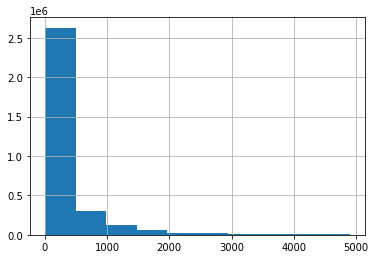

In [43]:
df['面積（㎡）'].hist()

In [70]:
df['取引単価'] = df['取引価格（総額）']/df['面積（㎡）']

In [86]:
df['建築年'].value_counts()

平成25年    53242
平成26年    53236
平成27年    51408
令和2年     49356
平成28年    49112
         ...  
昭和24年      338
昭和23年      325
昭和22年      268
昭和21年      183
令和5年       178
Name: 建築年, Length: 79, dtype: int64

In [87]:
df['最寄駅：距離（分）'].value_counts()

30分?60分    462803
1H?1H30    137236
8          127278
6          123207
9          122719
11         114669
4          101535
14          98523
10          98475
5           97073
13          95433
15          94471
7           87339
16          87073
3           79255
18          78762
19          74702
2H?         72374
20          64966
12          61523
21          60719
23          57782
1H30?2H     56598
25          51080
24          48842
2           47402
26          42450
28          41464
29          37598
1           29610
17          10482
22           6651
27           3845
0            3750
Name: 最寄駅：距離（分）, dtype: int64

In [110]:
df['最寄駅距離_修正'] = df['最寄駅：距離（分）']
df['最寄駅距離_修正'].loc[df['最寄駅距離_修正'] == '30分?60分'] = 45
df['最寄駅距離_修正'].loc[df['最寄駅距離_修正'] == '1H?1H30'] = 75
df['最寄駅距離_修正'].loc[df['最寄駅距離_修正'] == '1H30?2H'] = 105
df['最寄駅距離_修正'].loc[df['最寄駅距離_修正'] == '2H?'] = 135

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [111]:
df['最寄駅距離_修正'].value_counts(dropna=False)

45     462803
NaN    416582
75     137236
8      127278
6      123207
9      122719
11     114669
4      101535
14      98523
10      98475
5       97073
13      95433
15      94471
7       87339
16      87073
3       79255
18      78762
19      74702
135     72374
20      64966
12      61523
21      60719
23      57782
105     56598
25      51080
24      48842
2       47402
26      42450
28      41464
29      37598
1       29610
17      10482
22       6651
27       3845
0        3750
Name: 最寄駅距離_修正, dtype: int64

In [112]:
df['最寄駅距離_修正'] = df['最寄駅距離_修正'].astype(float)

In [113]:
df['最寄駅距離_修正'].value_counts(dropna=False)

45.0     462803
NaN      416582
75.0     137236
8.0      127278
6.0      123207
9.0      122719
11.0     114669
4.0      101535
14.0      98523
10.0      98475
5.0       97073
13.0      95433
15.0      94471
7.0       87339
16.0      87073
3.0       79255
18.0      78762
19.0      74702
135.0     72374
20.0      64966
12.0      61523
21.0      60719
23.0      57782
105.0     56598
25.0      51080
24.0      48842
2.0       47402
26.0      42450
28.0      41464
29.0      37598
1.0       29610
17.0      10482
22.0       6651
27.0       3845
0.0        3750
Name: 最寄駅距離_修正, dtype: int64

In [114]:
df['最寄駅距離_修正'].describe()

count    2.777689e+06
mean     2.626165e+01
std      2.799891e+01
min      0.000000e+00
25%      8.000000e+00
50%      1.600000e+01
75%      4.500000e+01
max      1.350000e+02
Name: 最寄駅距離_修正, dtype: float64

In [144]:
df['建築年'][df['建築年'].str[:2] == '平成'].value_counts(dropna=False)

平成25年    53242
平成26年    53236
平成27年    51408
平成28年    49112
平成29年    48277
平成30年    44401
平成31年    44262
平成3年     37353
平成2年     37174
平成7年     32544
平成8年     31861
平成9年     31105
平成4年     29884
平成10年    28967
平成6年     28437
平成24年    27231
平成12年    27085
平成11年    26491
平成17年    26388
平成18年    26231
平成15年    26225
平成13年    25713
平成19年    25662
平成14年    25270
平成5年     25099
平成20年    24815
平成16年    24734
平成21年    18675
平成23年    14312
平成22年    14038
Name: 建築年, dtype: int64

In [145]:
nenpyou = pd.read_excel('/content/drive/MyDrive/real_estate/nenpyou.xlsx')

In [146]:
nenpyou

,建築年,経過年数
0,令和5年,0
1,令和4年,1
2,令和3年,2
3,令和2年,3
4,令和1年,4
...,...,...
95,昭和5年,93
96,昭和4年,94
97,昭和3年,95
98,昭和2年,96


In [147]:
df = pd.merge(df, nenpyou, on='建築年', how='left')
df.shape

(3194271, 33)

In [149]:
df_mt = df[df['種類'] == '中古マンション等']
df_mt.shape

(528867, 33)

In [150]:
df_mt.isnull().sum()

No                 0
種類                 0
地域            528867
市区町村コード            0
都道府県名              0
市区町村名              0
地区名              160
最寄駅：名称           609
最寄駅：距離（分）       1157
取引価格（総額）           0
坪単価           528867
間取り            24199
面積（㎡）              0
取引価格（㎡単価）     528867
土地の形状         528867
間口            528867
延床面積（㎡）       528867
建築年            18606
建物の構造          18615
用途             90930
今後の利用目的        99506
前面道路：方位       528867
前面道路：種類       528867
前面道路：幅員（ｍ）    528867
都市計画            8834
建ぺい率（％）        11663
容積率（％）         11663
取引時点               0
改装             62572
取引の事情等        520881
取引単価               0
最寄駅距離_修正        1157
経過年数           18829
dtype: int64

In [151]:
df_mt.iloc[-1]

No                             24280
種類                          中古マンション等
地域                               NaN
市区町村コード                        47213
都道府県名                            沖縄県
市区町村名                           うるま市
地区名                              字塩屋
最寄駅：名称                           NaN
最寄駅：距離（分）                        NaN
取引価格（総額）                    15000000
坪単価                              NaN
間取り                             ３ＬＤＫ
面積（㎡）                             90
取引価格（㎡単価）                        NaN
土地の形状                            NaN
間口                               NaN
延床面積（㎡）                          NaN
建築年                            平成11年
建物の構造                             ＲＣ
用途                                住宅
今後の利用目的                          NaN
前面道路：方位                          NaN
前面道路：種類                          NaN
前面道路：幅員（ｍ）                       NaN
都市計画          市街化区域及び市街化調整区域外の都市計画区域
建ぺい率（％）                         60.0
容積率（％）                         100.0
取

In [152]:
df_mt_tk = df_mt[df_mt['都道府県名'] == '東京都']

In [153]:
df_mt_tk.shape

(155924, 33)

In [154]:
df_mt_tk.describe()

,No,市区町村コード,取引価格（総額）,坪単価,面積（㎡）,取引価格（㎡単価）,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）,取引単価,最寄駅距離_修正,経過年数
count,155924.000000,155924.000000,1.559240e+05,0.0,155924.000000,0.0,0.0,153832.000000,153832.000000,1.559240e+05,155773.000000,151595.000000
mean,126729.110278,13125.810311,3.485979e+07,NaN,47.437277,NaN,NaN,69.074185,355.218030,7.713460e+05,7.639187,24.237805
std,88282.361313,35.842502,3.416488e+07,NaN,26.868340,NaN,NaN,10.569321,153.430175,4.073497e+05,6.006438,12.554972
min,1.000000,13101.000000,1.000000e+04,NaN,10.000000,NaN,NaN,30.000000,50.000000,2.222222e+02,0.000000,1.000000
25%,49581.750000,13107.000000,1.900000e+07,NaN,25.000000,NaN,NaN,60.000000,200.000000,4.951786e+05,4.000000,15.000000
50%,112599.500000,13112.000000,2.800000e+07,NaN,50.000000,NaN,NaN,60.000000,300.000000,7.400000e+05,6.000000,21.000000
75%,192434.250000,13120.000000,4.200000e+07,NaN,65.000000,NaN,NaN,80.000000,500.000000,1.000000e+06,10.000000,33.000000
max,323428.000000,13303.000000,3.200000e+09,NaN,1400.000000,NaN,NaN,80.000000,1300.000000,2.450000e+07,135.000000,77.000000


In [155]:
df_mt_tk = df_mt_tk[(df_mt_tk['面積（㎡）'] < 100) & (df_mt_tk['取引単価'] < 2000000)]

In [156]:
df_mt_tk = df_mt_tk[df_mt_tk['最寄駅距離_修正'].isnull() == False]
df_mt_tk = df_mt_tk[df_mt_tk['最寄駅距離_修正'] <= 30]

In [157]:
df_mt_tk = df_mt_tk[df_mt_tk['経過年数'].isnull() == False]

In [163]:
df_mt_tk = df_mt_tk[df_mt_tk['容積率（％）'].isnull() == False]

In [164]:
df_mt_tk.isnull().sum()

No                 0
種類                 0
地域            145403
市区町村コード            0
都道府県名              0
市区町村名              0
地区名                1
最寄駅：名称             0
最寄駅：距離（分）          0
取引価格（総額）           0
坪単価           145403
間取り             6092
面積（㎡）              0
取引価格（㎡単価）     145403
土地の形状         145403
間口            145403
延床面積（㎡）       145403
建築年                0
建物の構造            771
用途             19859
今後の利用目的        25210
前面道路：方位       145403
前面道路：種類       145403
前面道路：幅員（ｍ）    145403
都市計画               2
建ぺい率（％）            0
容積率（％）             0
取引時点               0
改装             18265
取引の事情等        143832
取引単価               0
最寄駅距離_修正           0
経過年数               0
dtype: int64

In [180]:
df_mt_tk['容積率（％）'].value_counts(dropna = False)

200.0     37437
300.0     36877
400.0     24199
500.0     21613
600.0     13561
700.0      4775
150.0      3433
100.0      1772
800.0       835
80.0        814
60.0         46
1000.0       25
900.0        11
1200.0        2
1100.0        1
1300.0        1
50.0          1
Name: 容積率（％）, dtype: int64

In [182]:
df_mt_tk['建ぺい率（％）'].value_counts(dropna = False)

60.0    71550
80.0    69921
50.0     3070
40.0      818
30.0       44
Name: 建ぺい率（％）, dtype: int64

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_

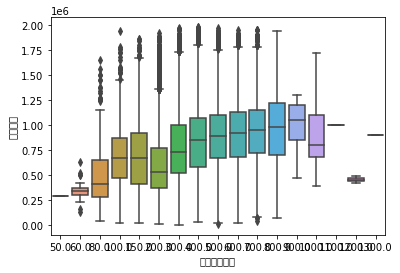

In [184]:
sns.boxplot(x = "容積率（％）", y = "取引単価", data = df_mt_tk)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_

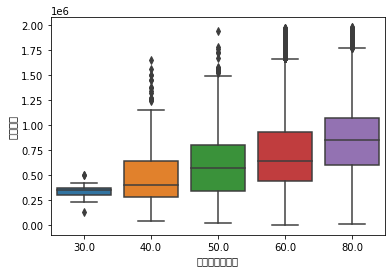

In [183]:
sns.boxplot(x = "建ぺい率（％）", y = "取引単価", data = df_mt_tk)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20385 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_

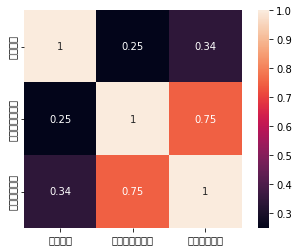

In [167]:
sns.heatmap(df_mt_tk[['取引単価','建ぺい率（％）','容積率（％）']].corr(), square = True, annot = True)

In [174]:
df_mt_tk['建物の構造'].value_counts()

ＲＣ          102396
ＳＲＣ          40980
鉄骨造           1060
ＳＲＣ、ＲＣ         128
ＲＣ、鉄骨造          41
軽量鉄骨造           15
ＳＲＣ、鉄骨造         10
木造               1
ＲＣ、軽量鉄骨造         1
Name: 建物の構造, dtype: int64

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65331 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65330 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36896 missing from current font.
  font.set_

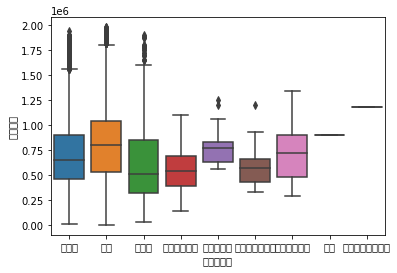

In [176]:
sns.boxplot(x = "建物の構造", y = "取引単価", data = df_mt_tk)

In [ ]:
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_

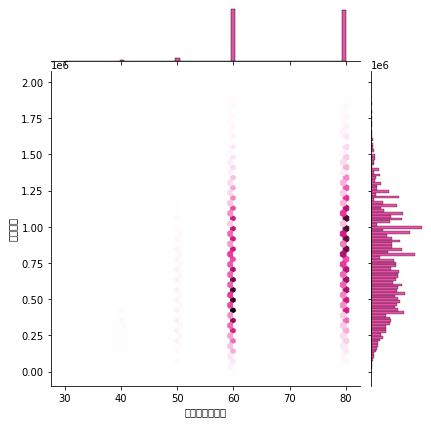

In [168]:
sns.jointplot(x=df_mt_tk['建ぺい率（％）'], y=df_mt_tk['取引単価'], kind="hex", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65285 missing from current font.
  font.set_

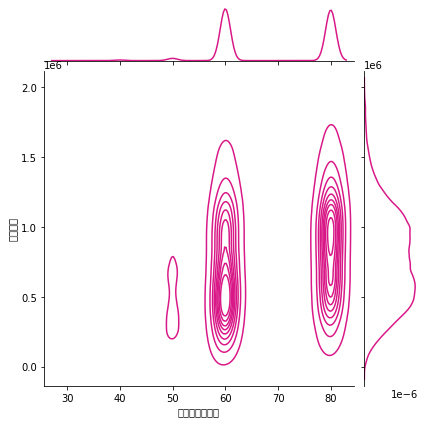

In [170]:
sns.jointplot(x=df_mt_tk['建ぺい率（％）'], y=df_mt_tk['取引単価'], kind="kde", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36942 missing from current font.
  font.set_te

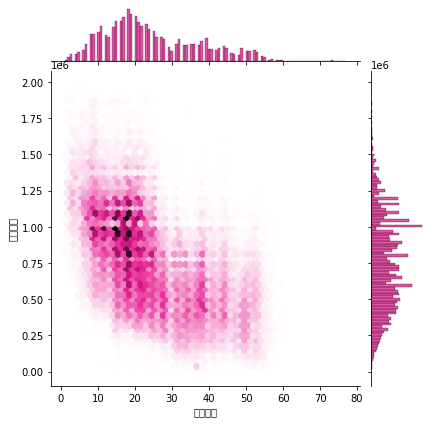

In [160]:
sns.jointplot(x=df_mt_tk['経過年数'], y=df_mt_tk['取引単価'], kind="hex", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36942 missing from current font.
  font.set_te

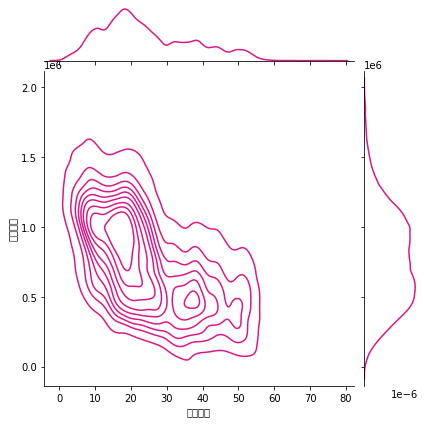

In [161]:
sns.jointplot(x=df_mt_tk['経過年数'], y=df_mt_tk['取引単価'], kind="kde", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38626 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38626 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_

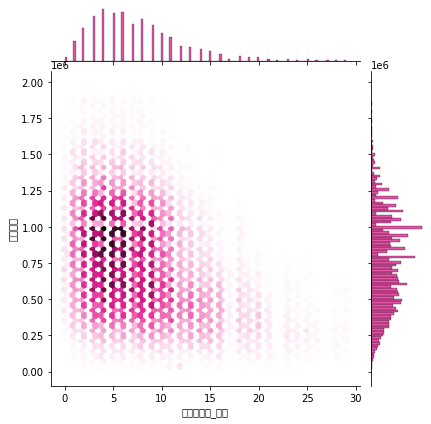

In [129]:
sns.jointplot(x=df_mt_tk['最寄駅距離_修正'], y=df_mt_tk['取引単価'], kind="hex", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38626 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38626 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_

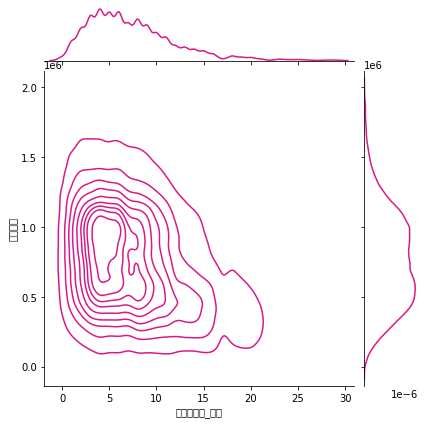

In [130]:
sns.jointplot(x=df_mt_tk['最寄駅距離_修正'], y=df_mt_tk['取引単価'], kind="kde", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_

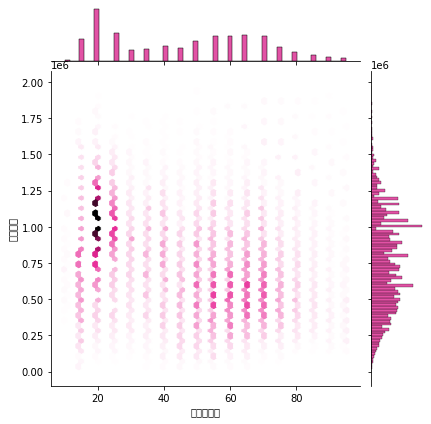

In [85]:
sns.jointplot(x=df_mt_tk['面積（㎡）'], y=df_mt_tk['取引単価'], kind="hex", color="#D91887")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_

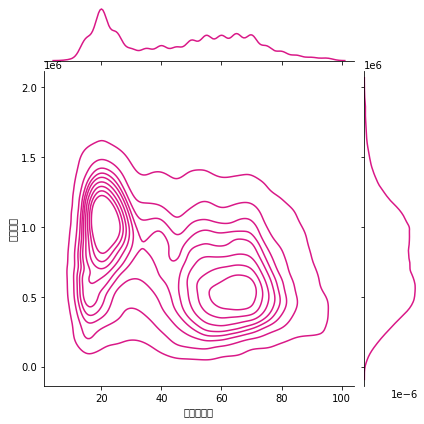

In [82]:
sns.jointplot(x=df_mt_tk['面積（㎡）'], y=df_mt_tk['取引単価'], kind="kde", color="#D91887")